# AUEB M.Sc. in Data Science

- Course: **Deep Learning**

- Semester: Spring 2020

- Instructor: Prof. P Malakasiotis

- Author: S. Politis (p3351814)

- Homework: 1

## Import required libraries and custom packages

In [1]:
import importlib
import logging
import numpy as np
import platform
import os
import pandas as pd
import pickle
import seaborn as sns
import sys
import talos
import tensorflow as tf
import tensorflow_addons as tfa
import time

Using TensorFlow backend.


In [2]:
sys.path.append("../code/")

from AUEB.DL.H001 import Examples
from AUEB.DL.H001 import Logger
from AUEB.DL.H001.Data import FashionMNISTReader
from AUEB.DL.H001.Evaluation import Evaluate
from AUEB.DL.H001.Visualization import Visualization
from AUEB.DL.H001.Model import MLP, CNN

## Setup globals

In [3]:
# Required for GraphViz.
if platform.system() == "Windows":
    os.environ["PATH"] += os.pathsep + "C:/Program Files (x86)/Graphviz2.38/bin/"
elif platform.system() == "Linux":
    os.environ["PATH"] += os.pathsep + "/usr/lib/x86_64-linux-gnu/graphviz"

log = Logger.create_logger(
    name = "msc-ds-dl-h-001", 
    level = logging.DEBUG
)

class_names = [
    "T-shirt/top", 
    "Trouser", 
    "Pullover", 
    "Dress", 
    "Coat",
    "Sandal", 
    "Shirt", 
    "Sneaker", 
    "Bag", 
    "Ankle boot"
]

Set the *Numpy* and *Tensorflow* seed so that stochasticity in repeated experimentation is removed and results are reproducible, especially when performing hyperparameter tuning.

In [4]:
random_seed = 19730618
np.random.seed(random_seed)
tf.random.set_seed = random_seed

Inspect our environment characteristics:

In [5]:
# Environment characteristics.
log.info(
    f"\n\nTensorflow ver.\t\t{tf.version.VERSION}\nBuilt with CUDA:\t{tf.test.is_built_with_cuda()}\nGPU:\t\t\t{tf.config.list_physical_devices('GPU')}"
)

2020-06-04 15:23:45,183	[INFO]	msc-ds-dl-h-001	<ipython-input-5-07dd36878476>.<module>: 

Tensorflow ver.		2.1.0
Built with CUDA:	True
GPU:			[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Ingest data

In [6]:
X_train, y_train = FashionMNISTReader.load_mnist(path = "../data/fashion",  kind = "train")
X_test, y_test = FashionMNISTReader.load_mnist(path = "../data/fashion",  kind = "t10k")

2020-06-04 15:23:45,437	[INFO]	msc-ds-dl-h-001	FashionMNISTReader.load_mnist: Done loading Fashion-MNIST train data
2020-06-04 15:23:45,477	[INFO]	msc-ds-dl-h-001	FashionMNISTReader.load_mnist: Done loading Fashion-MNIST t10k data


In [7]:
# Data shapes.
log.info(
    f"\n\nDataset shapes\n\nX_train\t{X_train.shape}\ny_train\t{y_train.shape}\nX_test\t{X_test.shape}\ny_test\t{y_test.shape}"
)

2020-06-04 15:23:45,481	[INFO]	msc-ds-dl-h-001	<ipython-input-7-349ebb213b47>.<module>: 

Dataset shapes

X_train	(60000, 784)
y_train	(60000,)
X_test	(10000, 784)
y_test	(10000,)


## Explore data

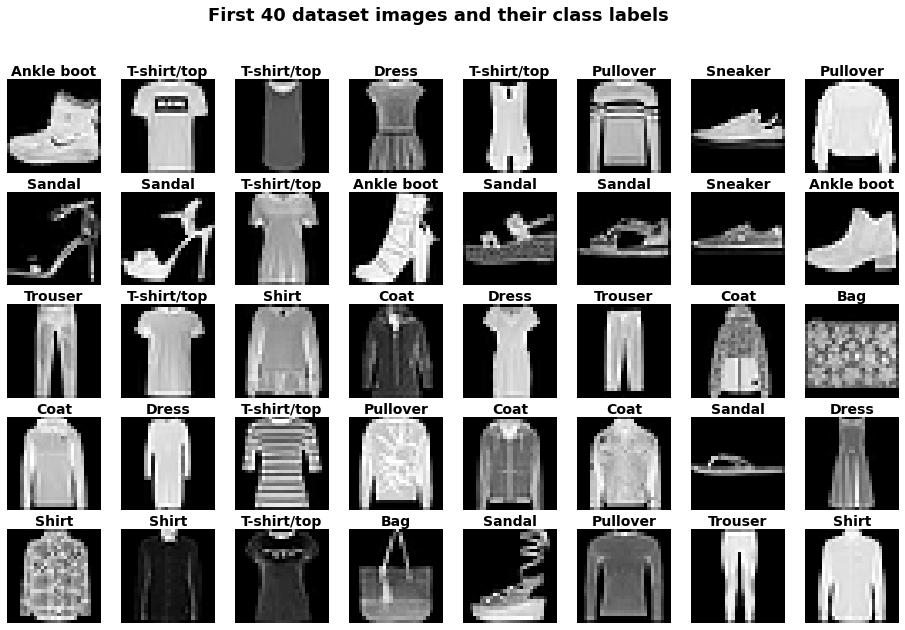

In [8]:
importlib.reload(Visualization)

n_images = 40

Visualization.plot_images(
    data = X_train[0:n_images, :], 
    labels = [class_names[i] for i in y_train[0:n_images]], 
    nrows = 5, 
    title = f"First {n_images} dataset images and their class labels", 
    figsize = (16, 10)
);

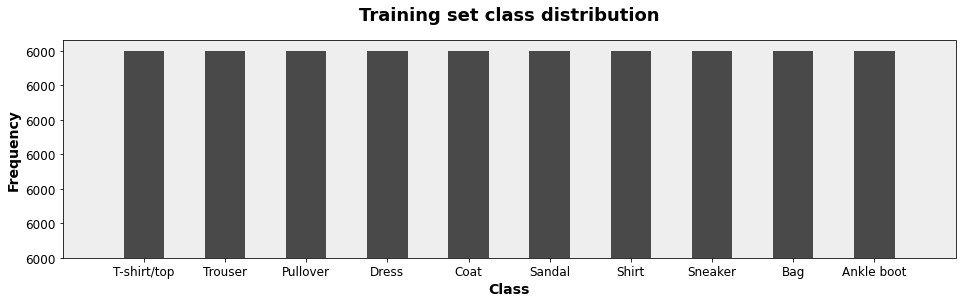

In [9]:
importlib.reload(Visualization)
Visualization.plot_hist(
    data = y_train.astype(np.int8), 
    x_label = "Class", 
    y_label = "Frequency", 
    x_tick_labels = class_names, 
    figsize = (16, 4), 
    title = "Training set class distribution"
);

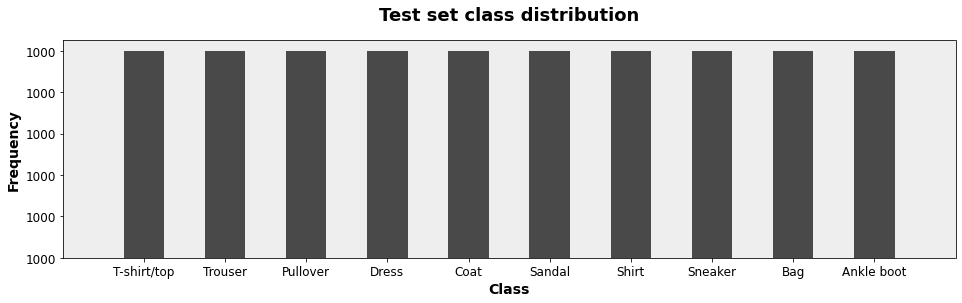

In [10]:
importlib.reload(Visualization)
Visualization.plot_hist(
    data = y_test.astype(np.int8), 
    x_label = "Class", 
    y_label = "Frequency", 
    x_tick_labels = class_names, 
    figsize = (16, 4), 
    title = "Test set class distribution"
);

We observe that the distribution of classes in both the training and the test set are uniformly distributed, hence the dataset does not present a class imbalance problem.  

## Convert dataset types

In [11]:
# Convert image data to np.float64.
# X_train = X_train.astype(np.float64)
# X_test = X_test.astype(np.float64)

In [12]:
# One-hot encode the target variables.
# y_train = tensorflow.keras.utils.to_categorical(y_train)
# y_test = tensorflow.keras.utils.to_categorical(y_test)

## Splitting data into train / dev / test sets

Since our dataset has already been split to train / test sets (*(X_train, y_train)*, *(X_test, y_test)* respectively), we shall proceed further by retaining a percentage ($0.1$) of the training data for creating a development set. The development set will be used for tuning hyperparameters of the model architectures, so as to acquire a robust model for inference.

We shall also be extra careful to retain the uniform nature of the target class distribution so as not to introduce bias. To do this, we shall split the sets in a stratified fashion.

In [13]:
import sklearn.model_selection

X_train, X_dev, y_train, y_dev = sklearn.model_selection.train_test_split(
    X_train, 
    y_train, 
    test_size = 0.2, 
    stratify = y_train, 
    random_state = random_seed, 
    shuffle = True
)

Inspecting the set dimensions:

In [14]:
# # Data shapes.
# log.info(
#     f"\n\nDataset shapes\n\nX_train\t{X_train.shape}\ny_train\t{y_train.shape}\nX_dev\t{X_dev.shape}\ny_dev\t{y_dev.shape}\nX_test\t{X_test.shape}\ny_test\t{y_test.shape}"
# )

Inspecting the set target class distributions:

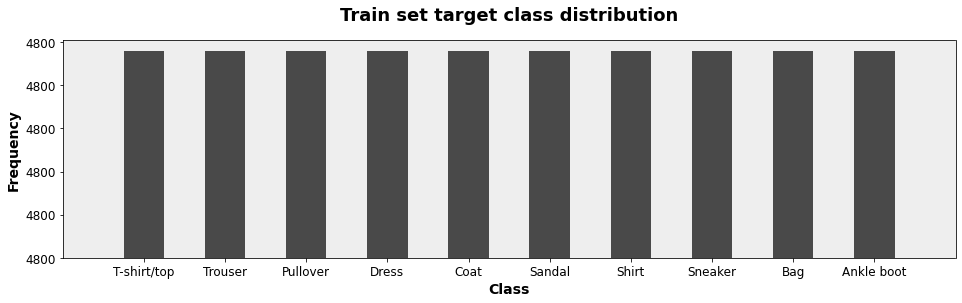

In [15]:
Visualization.plot_hist(
    data = y_train.astype(np.int8), 
    x_label = "Class", 
    y_label = "Frequency", 
    x_tick_labels = class_names, 
    figsize = (16, 4), 
    title = "Train set target class distribution"
);

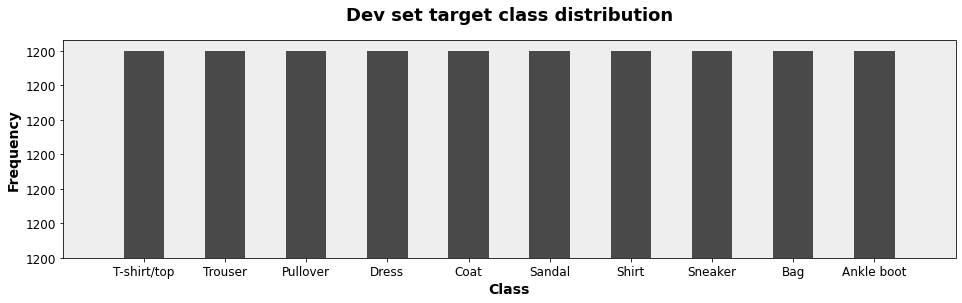

In [16]:
Visualization.plot_hist(
    data = y_dev.astype(np.int8), 
    x_label = "Class", 
    y_label = "Frequency", 
    x_tick_labels = class_names, 
    figsize = (16, 4), 
    title = "Dev set target class distribution"
);

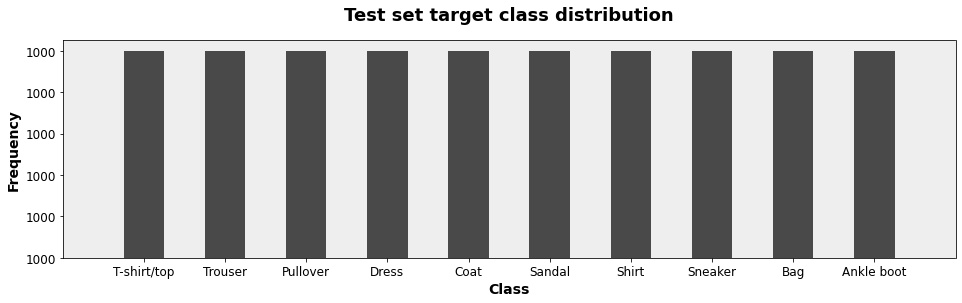

In [17]:
Visualization.plot_hist(
    data = y_test.astype(np.int8), 
    x_label = "Class", 
    y_label = "Frequency", 
    x_tick_labels = class_names, 
    figsize = (16, 4), 
    title = "Test set target class distribution"
);

## Normalize pixel values

The purpose of normalization is to fit the feature space to $[0, 1]$, because unscaled input variables can result in a slow or unstable learning process.

In [18]:
X_train = X_train / 255
X_dev = X_dev / 255
X_test = X_test / 255

In [19]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)

## Exploding / vanishing gradients example

In [20]:
# Vanishing gradients.
mean_vanishing, std_vanishing = Examples.gradients(minval = 0, maxval = 0.1, passes = 100)
print(f"Vanishing gradients: weights mean = {mean_vanishing}, std = {std_vanishing}")

# Exploding gradients.
mean_vanishing, std_vanishing = Examples.gradients(minval = 0, maxval = 10, passes = 100)
print(f"Exploding gradients: weights mean = {mean_vanishing}, std = {std_vanishing}")

Vanishing gradients: weights mean = (0.0,), std = 0.0
Exploding gradients: weights mean = (inf,), std = nan


### A NN with vanishing gradients

In [21]:
def tqdm_callback():
    return tfa.callbacks.TQDMProgressBar()

The purpose of this architecture is to illustrate the problem of *vanishing gradients*. The model architecture, 6-layer deep as well having 8 units per layer, showcases the problem. Interpreting the problem, we see that the *loss* and *val_loss* metrics do not diminish over time.

In [22]:
mlp = MLP.MLP(random_seed = random_seed)

In [23]:
model_name = f"fashion-mnist-mlp-vanishing-gradients{int(time.time())}"

mlp_vanishing_gradients = mlp.create(
    model_name = model_name, 
    input_shape = (784, ), 
    hidden_layers_spec = [
        {
            "units": 8, 
            "kernel_initializer": tf.random_uniform_initializer(minval = 0, maxval = 1, seed = random_seed), 
            "activation": "relu"
        }, 
        {
            "units": 8, 
            "kernel_initializer": tf.random_uniform_initializer(minval = 0, maxval = 1, seed = random_seed), 
            "activation": "relu"
        }, 
        {
            "units": 8, 
            "kernel_initializer": tf.random_uniform_initializer(minval = 0, maxval = 1, seed = random_seed), 
            "activation": "relu"
        }, 
        {
            "units": 8, 
            "kernel_initializer": tf.random_uniform_initializer(minval = 0, maxval = 1, seed = random_seed), 
            "activation": "relu"
        }, 
        {
            "units": 8, 
            "kernel_initializer": tf.random_uniform_initializer(minval = 0, maxval = 1, seed = random_seed), 
            "activation": "relu"
        }, 
        {
            "units": 8, 
            "kernel_initializer": tf.random_uniform_initializer(minval = 0, maxval = 1, seed = random_seed), 
            "activation": "relu"
        }
    ], 
    output_layer_spec = {
        "units": 10, 
        "kernel_initializer": tf.random_uniform_initializer(minval = 0, maxval = 1, seed = random_seed), 
        "activation": "softmax"
    }
)

In [24]:
mlp_vanishing_gradients.summary()

Model: "fashion-mnist-mlp-vanishing-gradients1591273427"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 8)                 6280      
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 8)                 72        
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 8)                 72        
_________________________________________________________________
hidden_layer_4 (Dense)       (None, 8)                 72        
_________________________________________________________________
hidden_layer_5 (Dense)       (None, 8)                 72        
_________________________________________________________________
hidden_layer_6 (Den

In [25]:
mlps = {
    "mlp_vanishing_gradients": mlp_vanishing_gradients
}

In [26]:
histories = {}

optimizer = tf.optimizers.Adam()

for mlp in mlps.items():
    mlp_label = mlp[0]
    mlp_model = mlp[1]
    
    log.info(f"Training model {mlp_label}")
    
    mlp_model.compile(
        optimizer = optimizer, 
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
        metrics = [ 
            "accuracy"
        ]
    )
    
    histories[mlp_label] = mlp_model.fit(
        X_train, 
        y_train, 
        epochs = 10, 
        batch_size = 32, 
        # validation_split = 0.1, 
        validation_data = (X_test, y_test), 
        callbacks = [
    #         early_stopping_callback(
    #             monitor = "val_loss", 
    #             patience = 5
    #         ), 
    #        tensor_board_callback(model_name = model_name), 
            tqdm_callback()
        ], 
        verbose = 0
    )

2020-06-04 15:23:47,802	[INFO]	msc-ds-dl-h-001	<ipython-input-26-9c697d84038b>.<module>: Training model mlp_vanishing_gradients


Epoch 1/10



Epoch 2/10



Epoch 3/10



Epoch 4/10



Epoch 5/10



Epoch 6/10



Epoch 7/10



Epoch 8/10



Epoch 9/10



Epoch 10/10


In [27]:
test_loss, test_accuracy = mlp_vanishing_gradients.evaluate(X_test, y_test)
test_loss, test_accuracy

10000/10000 [==============================] - 0s 36us/sample - loss: 2.3612 - accuracy: 0.1000


(2.3611501693725585, 0.1)

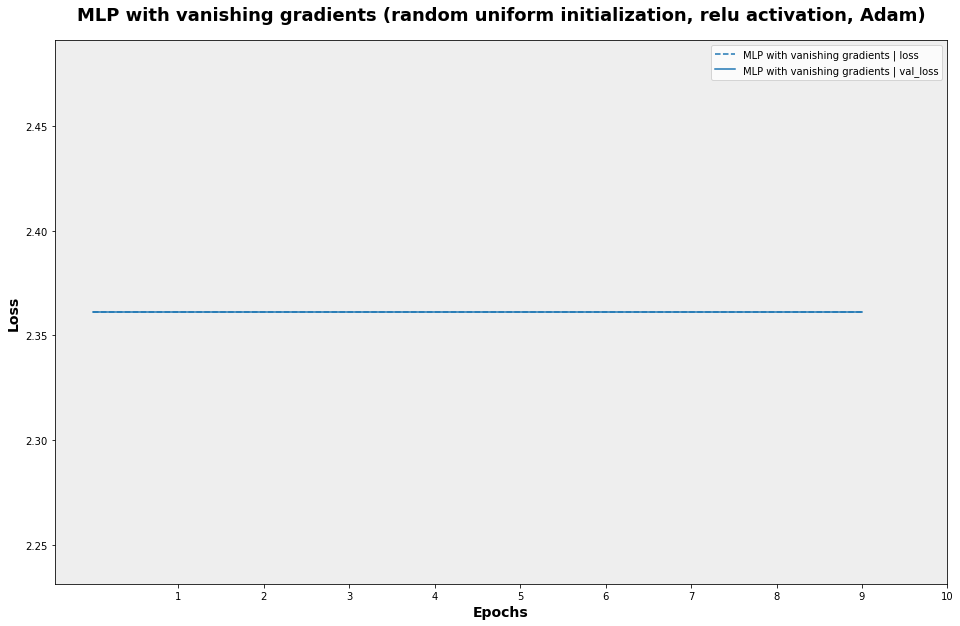

In [28]:
Visualization.plot_training_history(
    histories = {
        "MLP with vanishing gradients |": histories["mlp_vanishing_gradients"]
    }, 
    metrics = ["loss", "val_loss"], 
    epochs = 10, 
    figsize = (16, 10), 
    title = "MLP with vanishing gradients (random uniform initialization, relu activation, Adam)", 
    x_label = "Epochs", 
    y_label = "Loss"
);